<a href="https://colab.research.google.com/github/Devika532/Natural-Language-Processing/blob/main/NLP_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU available: True
Device: Tesla T4


In [ ]:
import transformers
transformers.__version__



'4.57.1'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm


In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0], sep="\t")

df = df.rename(columns={'tweet': 'text', 'subtask_a': 'label'})
df = df[['text','label']]
df['label'] = df['label'].map({'NOT':0,'OFF':1})
df.head()


Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv


,text,label
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


/tmp/ipython-input-1074234869.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index.map({0:"NOT",1:"OFF"}), y=label_counts.values, palette="Blues_d")


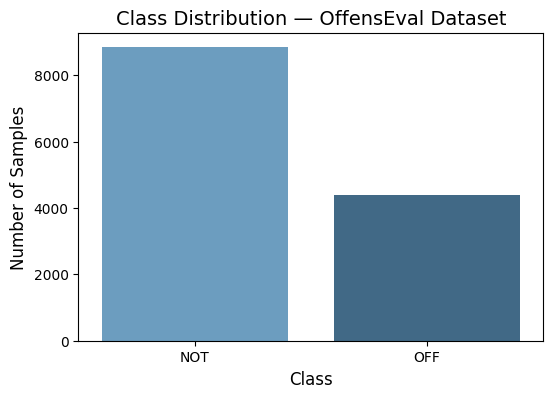

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index.map({0:"NOT",1:"OFF"}), y=label_counts.values, palette="Blues_d")
plt.title("Class Distribution — OffensEval Dataset", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.show()


In [ ]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class OffenseDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts, truncation=True, padding=True, max_length=128
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = OffenseDataset(train_df['text'].tolist(), train_df['label'].tolist())
test_dataset  = OffenseDataset(test_df['text'].tolist(), test_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} — Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 — Loss: 0.4639
Epoch 2 — Loss: 0.3523
Epoch 3 — Loss: 0.2315


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"]
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu()

        all_preds.extend(preds)
        all_labels.extend(labels)

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=["NOT","OFF"]))


              precision    recall  f1-score   support

         NOT       0.83      0.86      0.85      1768
         OFF       0.70      0.64      0.67       880

    accuracy                           0.79      2648
   macro avg       0.76      0.75      0.76      2648
weighted avg       0.79      0.79      0.79      2648



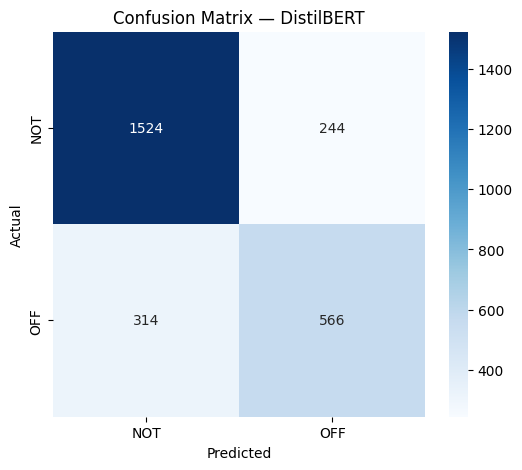

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["NOT","OFF"],
            yticklabels=["NOT","OFF"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — DistilBERT")
plt.show()


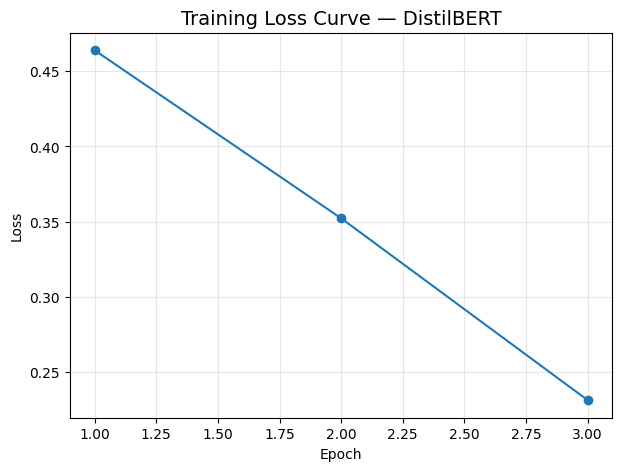

In [ ]:
training_loss_list = [0.4639, 0.3523, 0.2315]

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(range(1, len(training_loss_list)+1), training_loss_list, marker='o')
plt.title("Training Loss Curve — DistilBERT", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()
